## Imports

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

## Reading in Data

In [2]:
db = pd.read_csv("../datasets/cleaned.csv", )
db.head()

,complaint_number,status,date_entered,house_number,zip_code,house_street,special_district,complaint_category,unit,inspection_date,days_until_inspection,med_inc_zip
0,1245555,CLOSED,2009-01-02,930,10025,WEST END AVENUE,NOT SPECIAL,58,BOILR,2009-06-02,151,82352
1,1245608,CLOSED,2009-01-02,428,10013,BROADWAY,NOT SPECIAL,23,SCFLD,2009-10-09,280,106056
2,1245621,CLOSED,2009-01-02,146,10001,WEST 28 STREET,NOT SPECIAL,63,ELEVR,2009-01-22,20,85221
3,1245634,CLOSED,2009-01-03,388,10013,BROADWAY,NOT SPECIAL,56,BOILR,2009-01-07,4,106056
4,1245648,CLOSED,2009-01-03,375,10016,3 AVENUE,NOT SPECIAL,59,ELCTR,2009-01-08,5,109250


## Preprocessing

In [3]:
drop_cols = [
    "complaint_number",
    "days_until_inspection",
    "status",
    "house_number",
    "house_street",
]
clustering_db = db.drop(columns=drop_cols)

## Clustering

Since the dataset contains mostly categorical data and some numerical data as well, using a typical clustering algorithm like KMeans will not work. While we can one-hot encode the categorical columns, this does not give an effective range of numbers to base distances off of, so a more advanced method will be used, KPrototypes. This alogrithm splits the categorical and numerical data apart, and then applies KModes and KMeans, respectively, to the features to create the most appropriate clusters.

In [4]:
# refreshing on which columns are categorical
X.head()

,date_entered,zip_code,special_district,complaint_category,unit,inspection_date,med_inc_zip
0,2009-01-02,10025,NOT SPECIAL,58,BOILR,2009-06-02,82352
1,2009-01-02,10013,NOT SPECIAL,23,SCFLD,2009-10-09,106056
2,2009-01-02,10001,NOT SPECIAL,63,ELEVR,2009-01-22,85221
3,2009-01-03,10013,NOT SPECIAL,56,BOILR,2009-01-07,106056
4,2009-01-03,10016,NOT SPECIAL,59,ELCTR,2009-01-08,109250


## K-Modes Clustering

In order to find further connections between the complaint entries that may help the modeling phase, we are going to apply clustering as a form of EDA and feature engineering. As most of the data here is categorical, we are going to use the KModes modeling technique, which is an adaptation of KMeans clustering. As categorical data cannot truly have distances between values, KMeans is not an accurate tool for this scenario. Instead of numerical distances, KModes utilizes each row's combined values of each category (column, or feature), and determines for each cluster what the mode of that category  is. For each row, the number of columns where these values differs becomes the "distance". In this way, the algorithm can still determine the similarity and difference between the entries and the cluster "centroids".

For this process, we are only interested in the categorical columns that are going to have an impact on the modeling phase. Complaint status, address, and others are not needed for this analysis so they can be dropped. The included zip code median income will also be dropped as it is a continuous numerical feature and will not be available for the KModes algorithm.

In [5]:
drop_cols = [
    "complaint_number",
    "status",
    "date_entered",
    "house_number",
    "house_street",
    "inspection_date",
    "days_until_inspection",
    "med_inc_zip"
]

One of the difficult parts of clustering analysis is to determine the optimal number of clusters to choose (when using algorithms that cannot determine this on their own). To aid in this determination, we will loop through a range of cluster numbers, and analyze each model's cost, defined in the library documentation as the sum distance of all points to their respective cluster centroids, to determine the optimal number of clusters.

We will create a dictionary to store each of the model instances, with the number of clusters being used at the key for each model. We will also separately store the costs for each model to easily access these values. The targeted range of cluster numbers will be all numbers from 3 to 20.

In [30]:
# setting dictionary and lists to store models/results
km_models = {}
n_clusters = []
km_costs = []

# looping through cluster range
for i in range(3, 21, 1):
    print("running KModes with ", i, "clusters")
    
    # 
    n_clusters.append(i)
    km = KModes(n_clusters=i, n_init=10, random_state=42, n_jobs=-1, verbose=2)
    km_model = km.fit(X.drop(columns=drop_cols))
    km_models[i] = km_model
    km_costs.append(km_model.cost_)
    

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initializati

In [33]:
km_diffs = [0]
for i, cost in enumerate(km_costs[1:]):
    i_diff = cost - km_costs[i]
    km_diffs.append(i_diff)

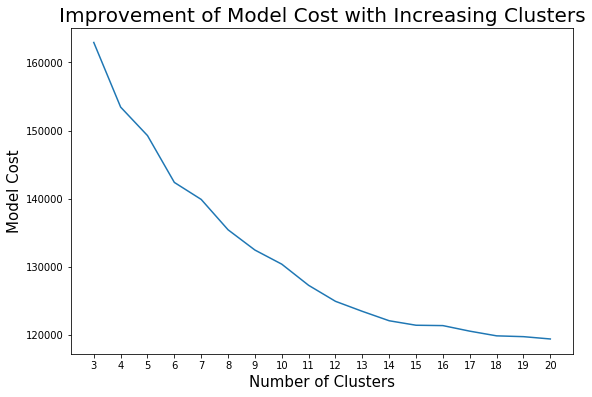

In [42]:
plt.figure(figsize=(9, 6))
plt.plot(n_clusters, km_costs)
plt.title("Improvement of Model Cost with Increasing Clusters", size=20)
plt.xticks(range(3, 21, 1))
plt.xlabel("Number of Clusters", size=15)
plt.ylabel("Model Cost", size=15);

When trying to identify the optimal number of clusters for use for modeling, it can be useful to identify an inflection point in the imetric curve, such as the "costs" displayed here. However, this curve does not have a single clear point to choose from. We will take a deeper look at the difference between these costs.

Text(0, 0.5, 'Change in Cost from Previous Model')

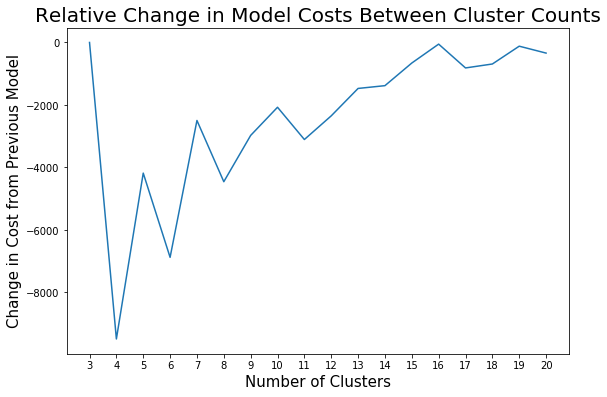

In [46]:
plt.figure(figsize=(9, 6))
plt.plot(n_clusters, km_diffs)
plt.title("Relative Change in Model Costs Between Cluster Counts", size=20)
plt.xticks(range(3, 21, 1))
plt.xlabel("Number of Clusters", size=15)
plt.ylabel("Change in Cost from Previous Model", size=15)

In [15]:
# kmodes = KModes(n_clusters=4, n_init=10, random_state=42, n_jobs=-1, verbose=1)

Initialization method and algorithm are deterministic. Setting n_init to 1.


In [7]:
# kmodes_model = kmodes.fit(X.drop(columns=drop_cols))

In [28]:
# # making new file
# outfile = open("kmodes_n4_pickle", "wb")

# # dumping model to pickle
# pickle.dump(kmodes_model, outfile)

# # closing new file
# outfile.close()

In [8]:
# opening pickle file
infile = open("kmodes_n4_pickle", "rb")

# unpickling back into model object
kmodes_model = pickle.load(infile)

infile.close()

In [9]:
kmodes_model.cluster_centroids_

array([['11419', 'NOT SPECIAL', '45', 'QNS.'],
       ['11221', 'NOT SPECIAL', '05', 'BKLYN'],
       ['11355', 'NOT SPECIAL', '63', 'ELEVR'],
       ['11211', 'NOT SPECIAL', '04', 'ERT  ']], dtype='<U21')

In [10]:
kmodes_model.cost_

153435.0

In [11]:
db["cluster"] = kmodes_model.labels_

In [12]:
db["cluster"].value_counts(normalize=True)

0    0.605569
1    0.194700
2    0.103726
3    0.096005
Name: cluster, dtype: float64

In [25]:
db.columns

Index(['complaint_number', 'status', 'date_entered', 'house_number',
       'zip_code', 'house_street', 'special_district', 'complaint_category',
       'unit', 'inspection_date', 'days_until_inspection', 'med_inc_zip',
       'cluster'],
      dtype='object')

In [23]:
db.groupby("cluster")["days_until_inspection"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,45018.0,91.282465,211.480531,1.0,6.0,27.0,88.0,3756.0
1,14474.0,94.829004,205.692277,1.0,6.0,32.0,94.0,3767.0
2,7711.0,55.944236,84.096290,1.0,9.0,27.0,64.0,1426.0
3,7137.0,79.153566,282.582512,1.0,1.0,3.0,17.0,3251.0


The clusters do not seem to have created any large distinction between the wait times for inspection, but perhaps they have made better groups in one of the other features.

In [24]:
db.groupby("cluster")["med_inc_zip"].median()

cluster
0    61090
1    53151
2    46013
3    64152
Name: med_inc_zip, dtype: int64

In [28]:
db.groupby("cluster")["complaint_category"].describe()

,count,unique,top,freq
cluster,,,,
0,45018,108,45,12299
1,14474,82,05,7639
2,7711,55,63,5497
3,7137,80,04,2279


When looking at the median income for each of the clusters, there again does not appear to be a large separation between them. Shifting to the complaint categories, we can clearly see why these points were chosen as the centroids, as each cluster's most common (mode) complaint entry is the same as that feature's centroid value

## K-Prototypes Clustering

In [4]:
X.head()

,date_entered,zip_code,special_district,complaint_category,unit,inspection_date,med_inc_zip
0,2009-01-02,10025,NOT SPECIAL,58,BOILR,2009-06-02,82352
1,2009-01-02,10013,NOT SPECIAL,23,SCFLD,2009-10-09,106056
2,2009-01-02,10001,NOT SPECIAL,63,ELEVR,2009-01-22,85221
3,2009-01-03,10013,NOT SPECIAL,56,BOILR,2009-01-07,106056
4,2009-01-03,10016,NOT SPECIAL,59,ELCTR,2009-01-08,109250


In [9]:
X_kp = X.drop(columns=["date_entered", "inspection_date"])

In [10]:
X_kp.head()

,zip_code,special_district,complaint_category,unit,med_inc_zip
0,10025,NOT SPECIAL,58,BOILR,82352
1,10013,NOT SPECIAL,23,SCFLD,106056
2,10001,NOT SPECIAL,63,ELEVR,85221
3,10013,NOT SPECIAL,56,BOILR,106056
4,10016,NOT SPECIAL,59,ELCTR,109250


In [11]:
# kp = KPrototypes(n_clusters=4, n_jobs=-1, verbose=1, random_state=42)    
# kp_model = kprot.fit(X_kp, categorical=[0, 1, 2, 3])

In [14]:
kp_models = {}
n_clusters = []
kp_model_costs = []

for i in range(3, 21, 1):
    print("Fitting model with n_clusters =", i)
    n_clusters.append(i)
    kp = KPrototypes(n_clusters=i, n_init=10, random_state=42, n_jobs=-1, verbose=2)
    kp_model = kp.fit(X_kp, categorical=[0, 1, 2, 3])
    kp_models[i] = (kp_model)
    kp_model_costs.append(kp_model.cost_)

Fitting model with n_clusters = 3
Best run was number 1
Fitting model with n_clusters = 4
Best run was number 7
Fitting model with n_clusters = 5
Best run was number 1
Fitting model with n_clusters = 6
Best run was number 4
Fitting model with n_clusters = 7
Best run was number 1
Fitting model with n_clusters = 8
Best run was number 2
Fitting model with n_clusters = 9
Best run was number 10
Fitting model with n_clusters = 10
Best run was number 9
Fitting model with n_clusters = 11


KeyboardInterrupt: 

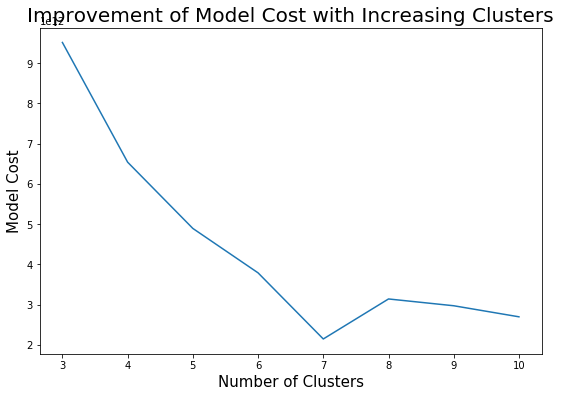

In [26]:
plt.figure(figsize=(9, 6))
plt.plot(n_clusters[:8], kp_model_costs)
plt.title("Improvement of Model Cost with Increasing Clusters", size=20)
plt.xticks(n_clusters[:8])
plt.xlabel("Number of Clusters", size=15)
plt.ylabel("Model Cost", size=15);

In [29]:
kp_diffs = [0]
for i, cost in enumerate(kp_model_costs[1:]):
    i_diff = cost - kp_model_costs[i]
    kp_diffs.append(i_diff)

Text(0, 0.5, 'Change in Cost from Previous Model')

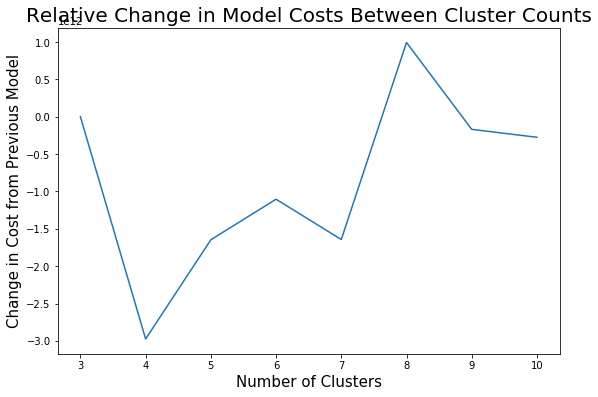

In [32]:
plt.figure(figsize=(9, 6))
plt.plot(n_clusters[:8], kp_diffs)
plt.title("Relative Change in Model Costs Between Cluster Counts", size=20)
plt.xticks(n_clusters[:8])
plt.xlabel("Number of Clusters", size=15)
plt.ylabel("Change in Cost from Previous Model", size=15)

In [38]:
kp_models[4].cluster_centroids_

[array([[ 83750.00243427],
        [ 60152.13747653],
        [ 38428.95000603],
        [120111.74915825]]), array([['10025', 'NOT SPECIAL', '45', 'QNS.'],
        ['11419', 'NOT SPECIAL', '45', 'QNS.'],
        ['11355', 'NOT SPECIAL', '45', 'BKLYN'],
        ['11215', 'NOT SPECIAL', '05', 'MAN.']], dtype='<U21')]

In [40]:
kp_models[7].cluster_centroids_

[array([[117942.37745546],
        [243456.02597403],
        [ 32473.05569235],
        [ 47062.06948008],
        [ 57145.36692136],
        [ 67016.08465568],
        [ 84861.95955584]]), array([['11215', 'NOT SPECIAL', '05', 'MAN.'],
        ['10007', 'NOT SPECIAL', '05', 'MAN.'],
        ['11355', 'NOT SPECIAL', '63', 'ELEVR'],
        ['11221', 'NOT SPECIAL', '45', 'BKLYN'],
        ['11216', 'NOT SPECIAL', '45', 'QNS.'],
        ['11419', 'NOT SPECIAL', '45', 'QNS.'],
        ['10025', 'NOT SPECIAL', '05', 'QNS.']], dtype='<U21')]

Running K-Modes and K-Prototypes with the same cluster number, but the additional feature of median income, does give different clusters/centroids. Given the significant increase in processing time between KModes and KPrototypes, it may be more efficient to only use KModes on the categorical features to cluster the datapoints, then integrate the income data as a feature in the final predictive model.

In [43]:
# saving n=4, n=7 kp models

# making new file
outfile = open("kp_n4_pickle", "wb")

# dumping model to pickle
pickle.dump(kp_models[4], outfile)

# closing new file
outfile.close()

outfile = open("kp_n7_pickle", "wb")
pickle.dump(kp_models[7], outfile)
outfile.close()

## Saving Dataset

The cluster labels from the optimized K-Modes model were applied to the cleaned dataset, which will now be saved for use in the main modeling notebook.

In [41]:
db.to_csv("../datasets/cleaned_clustered.csv", index=False)